In [67]:
!pip install tensorflow

In [68]:
!pip install keras.utils 

In [69]:
%tensorflow_version 2.x

In [70]:
import os
import pickle
import numpy as np
from music21 import note, chord, corpus, converter, stream, instrument
import glob
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm

In [71]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
!ls "/content/drive/My Drive"

 17_Trupti_Jagtap_SYMCA_2020-2021_Sem_1_PPL_10.pdf
 17_Trupti_Jagtap_SYMCA_2020-2021_Sem_1_PPL_7.pdf
 17_Trupti_Jagtap_SYMCA_2020-2021_Sem_1_PPL_8.PNG
'17_Trupti_Jagtap_SYMCA_2020_21_Sem_1_PPL_10 (1).pdf'
 17_Trupti_Jagtap_SYMCA_2020_21_Sem_1_PPL_10.pdf
 17_Trupti_Jagtap_SYMCA_2020_21_Sem_1_PPL_11.pdf
 17_Trupti_Jagtap_SYMCA_2020_21_Sem_1_PPL_12.pdf
 17_Trupti_Jagtap_SYMCA_2020_21_Sem_1_PPL_7.pdf
 17_Trupti_Jagtap_SYMCA_2020_21_Sem_1_PPL_8.pdf
 17_Trupti_Jagtap_SYMCA_2020_21_Sem_1_PPL_9.pdf
 17_TYMCA_CC_1.pdf
 20211012_165422.jpg
 20220122_200256.jpg
 20220123_165746.jpg
 20220123_165854.jpg
 20220123_170016.jpg
 20220123_170035.jpg
'20220123_170105 (1).jpg'
 20220123_170105.jpg
 20220123_171440.jpg
 20220123_171445.jpg
 20220123_171503.jpg
 22.m4a
 6_feb.m4a
'Aajkal Tere Mere.mp3'
'aajkal tere mere ukelele.m4a'
'aajkal tere mere voice.m4a'
'Akka Birthday.mp4'
'Applicant_List_for_2021-2022_Analyst_(RW01)_at_Capgemini (3).xlsx'
 archive.zip
 Assignment_2_CC.pdf
'Assignment_3_CC_Roll_No_

In [73]:

!unzip -u "/content/drive/MyDrive/MIDI_collection.zip" -d "/content/drive/MyDrive/midi_files_dataset"

Archive:  /content/drive/MyDrive/MIDI_collection.zip
   creating: /content/drive/MyDrive/midi_files_dataset/archive/data/
  inflating: /content/drive/MyDrive/midi_files_dataset/archive/data/[ajin_op]_yoru_wa_nemureru_kai_-__flumpool__fonzi_m_.mid  
  inflating: /content/drive/MyDrive/midi_files_dataset/archive/data/[ao_no_kanata_no_four_rhythm_op]_contrail_kiseki__fonzi_m_.mid  
  inflating: /content/drive/MyDrive/midi_files_dataset/archive/data/[boku_dake_ga_inai_machi_ed]_sore_wa_chiisana_hikari_no_youna_-_sayuri__fonzi_m_performance_.mid  
  inflating: /content/drive/MyDrive/midi_files_dataset/archive/data/[charlotte_op]_bravely_you_-_lia_(fonzi_m).mid  
  inflating: /content/drive/MyDrive/midi_files_dataset/archive/data/[divine_gate_op]_one-me_two-hearts_-_hitorie__fonzi_m_.mid  
  inflating: /content/drive/MyDrive/midi_files_dataset/archive/data/[dragon_ball_super_op_1]_chouzetsu_dynamic!_(fonzi_m).mid  
  inflating: /content/drive/MyDrive/midi_files_dataset/archive/data/[eromanga

In [74]:
data_dir = "/content/drive/MyDrive/midi_files_dataset/archive/data"

# list of files
midi_list = os.listdir(data_dir)

# Load and make list of stream objects
original_scores = []
for midi in tqdm(midi_list):
    score = converter.parse(os.path.join(data_dir,midi))
    original_scores.append(score)

  0%|          | 0/240 [00:00<?, ?it/s]

In [75]:
# Merge notes into chords
original_scores = [midi.chordify() for midi in tqdm(original_scores)]

  0%|          | 0/240 [00:00<?, ?it/s]

In [77]:
# Define empty lists of lists
original_chords = [[] for _ in original_scores]
original_durations = [[] for _ in original_scores]
original_keys = []

# Extract notes, chords, durations, and keys
for i, midi in tqdm(enumerate(original_scores)):
    original_keys.append(str(midi.analyze('key')))
    for element in midi:
        if isinstance(element, note.Note):
            original_chords[i].append(element.pitch)
            original_durations[i].append(element.duration.quarterLength)
        elif isinstance(element, chord.Chord):
            original_chords[i].append('.'.join(str(n) for n in element.pitches))
            original_durations[i].append(element.duration.quarterLength)

0it [00:00, ?it/s]

In [78]:
# Create list of chords and durations from songs in C major
major_chords = [c for (c, k) in tqdm(zip(original_chords, original_keys)) if (k == 'C major')]
major_durations = [c for (c, k) in tqdm(zip(original_durations, original_keys)) if (k == 'C major')]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [79]:
def get_distinct(elements):
    # Get all pitch names
    element_names = sorted(set(elements))
    n_elements = len(element_names)
    return (element_names, n_elements)

def create_lookups(element_names):
    # create dictionary to map notes and durations to integers
    element_to_int = dict((element, number) for number, element in enumerate(element_names))
    int_to_element = dict((number, element) for number, element in enumerate(element_names))

    return (element_to_int, int_to_element)

In [81]:
store_folder = 'parsed_data1'
os.mkdir(store_folder)

In [82]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct([n for chord in major_chords for n in chord])
duration_names, n_durations = get_distinct([d for dur in major_durations for d in dur])
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

In [83]:
# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [84]:
print("Unique Notes={} and Duration values={}".format(n_notes,n_durations))

Unique Notes=2416 and Duration values=40


In [85]:
# Set sequence length
sequence_length = 32

# Define empty array for train data
train_chords = []
train_durations = []
target_chords = []
target_durations = []

# Construct train and target sequences for chords and durations
for s in range(len(major_chords)):
    chord_list = [note_to_int[c] for c in major_chords[s]]
    duration_list = [duration_to_int[d] for d in major_durations[s]]
    for i in range(len(chord_list) - sequence_length):
        train_chords.append(chord_list[i:i+sequence_length])
        train_durations.append(duration_list[i:i+sequence_length])
        target_chords.append(chord_list[i+1])
        target_durations.append(duration_list[i+1])

In [86]:
train_chords = np.array(train_chords)
train_durations = np.array(train_durations)
target_chords = np.array(target_chords)
target_durations = np.array(target_durations)

In [87]:
def create_network(n_notes, n_durations, embed_size = 100, rnn_units = 256):
    """ create the structure of the neural network """

    notes_in = Input(shape = (None,))
    durations_in = Input(shape = (None,))

    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in) 

    x = Concatenate()([x1,x2])

    x = LSTM(rnn_units, return_sequences=True)(x)

    x = LSTM(rnn_units, return_sequences=True)(x)

    # attention
    e = Dense(1, activation='tanh')(x)
    e = Reshape([-1])(e)
    alpha = Activation('softmax')(e)

    alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))

    c = Multiply()([x, alpha_repeated])
    c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    
                                    
    notes_out = Dense(n_notes, activation = 'softmax', name = 'pitch')(c)
    durations_out = Dense(n_durations, activation = 'softmax', name = 'duration')(c)
   
    model = Model([notes_in, durations_in], [notes_out, durations_out])
    model.compile(loss=['sparse_categorical_crossentropy', 
                        'sparse_categorical_crossentropy'], optimizer=RMSprop(lr = 0.001))

    return model

In [88]:
embed_size = 128
rnn_units = 128

In [89]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from tensorflow.keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from tensorflow.keras.layers import Multiply, Lambda, Softmax
import tensorflow.keras.backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

In [90]:
model = create_network(n_notes, n_durations, embed_size, rnn_units)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [91]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 128)    309248      ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 128)    5120        ['input_4[0][0]']                
                                                                                            

In [93]:
os.mkdir('outputs1')
os.mkdir('outputs1/output')
os.mkdir('outputs1/weights')

In [95]:
output_folder = 'outputs'
weights_folder = os.path.join(output_folder, 'weights')


checkpoint = ModelCheckpoint(
    os.path.join(weights_folder, "model2.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

epoch_checkpoint = ModelCheckpoint(
    os.path.join(weights_folder, "weights-{epoch:02d}-{loss:.4f}.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 5
)


callbacks_list = [
    checkpoint
    , epoch_checkpoint
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "model2.h5"))

In [96]:
history = model.fit([train_chords, train_durations], 
                    [target_chords, target_durations]
                    , epochs=100, batch_size=128
                    , callbacks=callbacks_list
                    , shuffle=True
                  )

Epoch 1/100
51/51 [==============================] - 21s 309ms/step - loss: 9.1672 - pitch_loss: 7.4203 - duration_loss: 1.7470
Epoch 2/100
51/51 [==============================] - 16s 307ms/step - loss: 8.1585 - pitch_loss: 6.9315 - duration_loss: 1.2269
Epoch 3/100
51/51 [==============================] - 15s 304ms/step - loss: 7.7539 - pitch_loss: 6.6498 - duration_loss: 1.1042
Epoch 4/100
51/51 [==============================] - 16s 315ms/step - loss: 7.4990 - pitch_loss: 6.4553 - duration_loss: 1.0437
Epoch 5/100
51/51 [==============================] - 17s 334ms/step - loss: 7.2923 - pitch_loss: 6.2940 - duration_loss: 0.9983
Epoch 6/100
51/51 [==============================] - 16s 308ms/step - loss: 7.1007 - pitch_loss: 6.1472 - duration_loss: 0.9535
Epoch 7/100
51/51 [==============================] - 16s 308ms/step - loss: 6.9550 - pitch_loss: 6.0279 - duration_loss: 0.9270
Epoch 8/100
51/51 [==============================] - 16s 309ms/step - loss: 6.8139 - pitch_loss: 5.9209 

In [99]:
from matplotlib import pyplot as plt

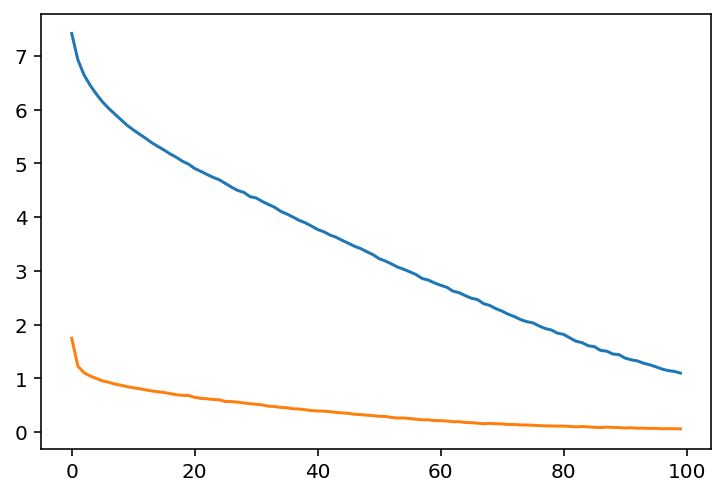

In [100]:
# get plots
plt.plot(history.history['pitch_loss'])
plt.plot(history.history['duration_loss'])
plt.show()

In [101]:
def sample_with_temp(preds, temperature):

    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [103]:
# chord and duration sequences
initial_chords = np.expand_dims(train_chords[0,:].copy(), 0)
initial_durations = np.expand_dims(train_durations[0,:].copy(), 0)

In [104]:
initial_chords

array([[1620, 1669, 1620, 1669, 1620, 1629, 1620, 1669, 1620, 1629, 1620,
        1669, 1620, 1669, 1663, 1756, 1623, 1620, 1669, 1629, 1620, 1669,
        1620, 1629, 1669, 1662, 1669, 1620, 1629, 1669, 1620, 1669]])

In [105]:
initial_durations

array([[7, 2, 2, 2, 1, 0, 2, 3, 1, 0, 2, 2, 2, 2, 2, 2, 1, 0, 1, 0, 1, 2,
        0, 1, 0, 2, 2, 0, 1, 0, 2, 2]])

In [106]:
# Function to predict chords and durations
def predict_chords(chord_sequence, duration_sequence,model,temperature=1.0):
    predicted_chords, predicted_durations = model.predict([chord_sequence, duration_sequence])
    return sample_with_temp(predicted_chords[0],temperature), sample_with_temp(predicted_durations[0],temperature)

In [107]:
# Define empty lists for generated chords and durations
new_chords, new_durations = [], []

# Generate chords and durations using 50 rounds of prediction
for j in range(50):
    new_chord, new_duration = predict_chords(initial_chords, 
                                             initial_durations,
                                             model,
                                             temperature=0.8)
    new_chords.append(new_chord)
    new_durations.append(new_duration)
    initial_chords[0][:-1] = initial_chords[0][1:]
    initial_chords[0][-1] = new_chord
    initial_durations[0][:-1] = initial_durations[0][1:]
    initial_durations[0][-1] = new_duration

In [63]:
# Create stream object and add guitar as instrument
generated_stream = stream.Stream()
generated_stream.append(instrument.Piano())

# Add notes and durations to stream
for j in range(len(new_chords)):
    try:
        generated_stream.append(note.Note(int_to_note[new_chords[j]].replace('.', ' '), 
                                          quarterType = int_to_duration[new_durations[j]]))
    except:
        generated_stream.append(chord.Chord(int_to_note[new_chords[j]].replace('.', ' '), 
                                            quarterType = int_to_duration[new_durations[j]]))

# Export as MIDI file
generated_stream.write('midi', fp='lstm_50epoch.mid')

'lstm_50epoch.mid'

In [108]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
from midi2audio import FluidSynth
from IPython.display import Audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [109]:
FluidSynth("font.sf2").midi_to_audio('lstm_50epoch.mid', 
                                     'lstm_50epoch.wav')

In [110]:
Audio("lstm_50epoch.wav")

In [59]:
!zip -r outputs.zip outputs

  adding: outputs/ (stored 0%)
  adding: outputs/output/ (stored 0%)
  adding: outputs/weights/ (stored 0%)
  adding: outputs/weights/weights-82-2.0187.h5 (deflated 8%)
  adding: outputs/weights/weights-74-2.4142.h5 (deflated 8%)
  adding: outputs/weights/weights-64-2.9811.h5 (deflated 8%)
  adding: outputs/weights/weights-16-6.3143.h5 (deflated 8%)
  adding: outputs/weights/weights-54-3.5630.h5 (deflated 8%)
  adding: outputs/weights/weights-04-7.9236.h5 (deflated 8%)
  adding: outputs/weights/weights-99-1.2506.h5 (deflated 8%)
  adding: outputs/weights/weights-58-3.3175.h5 (deflated 8%)
  adding: outputs/weights/weights-92-1.5301.h5 (deflated 8%)
  adding: outputs/weights/weights-89-1.6666.h5 (deflated 8%)
  adding: outputs/weights/weights-08-7.1841.h5 (deflated 8%)
  adding: outputs/weights/weights-20-5.9692.h5 (deflated 8%)
  adding: outputs/weights/weights-01-9.3245.h5 (deflated 8%)
  adding: outputs/weights/weights-61-3.1684.h5 (deflated 8%)
  adding: outputs/weights/weights-30-5

In [60]:
!ls -ltrh

total 826M
drwxr-xr-x 1 root root 4.0K May  3 13:42 sample_data
drwx------ 5 root root 4.0K May 15 12:10 drive
drwxr-xr-x 2 root root 4.0K May 15 12:30 parsed_data
drwxr-xr-x 4 root root 4.0K May 15 12:42 outputs
-rw-r--r-- 1 root root 1.1K May 15 13:08 lstm_50epoch.mid
-rw-r--r-- 1 root root 142M May 15 13:14 font.sf2
-rw-r--r-- 1 root root 4.2M May 15 13:14 lstm_50epoch.wav
-rw-r--r-- 1 root root 680M May 15 13:17 outputs.zip
